## Maze Generator and Solver
This project aims to create an agent that can solve any maze. The first half of the code involves generating random mazes of any size (which was actually the more difficult part of the project). The only boundaries are that the generated maze will always be square and the maze dimensions must be odd in order for the maze to "fill up". There is no theoretical  upper bound on maze size but mazes larger than 150pixels may take more than a minute to generate. The smallest maze possible is 9x9 because mazes of size 7x7 and below simpy don't have enough space to generate tunnels (since tunnels are generated 2 pixels at a time to ensure that there is always space (walls) between all tunnels and maze perimeter is 2 pixels thick so that the "pick new spot" function (which decides where to tunnel) doesn't go out of bounds. Start spots are always on the left wall and end spots are picked randomly from dead ends that touch walls other than the start spot.

I hard coded the rat with a solving algorithm where the rat will explore forward and only retrace its own path (go backwards) when it hits a dead end. The rat's track can then be used to quickly find the shortest possible path. This code is therefore most useful for generating random mazes of varying sizes and subsequently returning the single shortest path for that maze. Generated mazes have only one solution.  

In [1]:
#figure out how to show solving as an animation?

#NOTE: 
#THIS CODE IS FOR ALL SQUARE ODD MAZE SIZES 
#THIS CODE HAS WORKING/TESTING JUNK REMOVED 

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from pandas import*
import random

# Step One: creating the maze area (matrix)
First I started with creating a matrix to form the outline or area for the maze to be generated in. By default the matrix is filled with 1s which will eventually form the walls for maze "tunnels". I created a border designated by 2s. Initially I had the walls just be one pixel thick, but I encountered out of bound errors when adding the maze tunnels  because the tunnels always go foward two spots at a time. Therefore I made the walls 2 pixels thick. 

I also made the maze square, in order to ensure they are always square the user may only enter a single dimension when generating a maze.

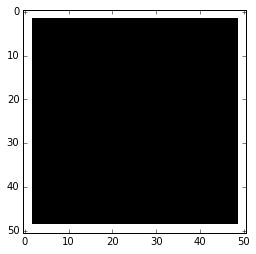

In [4]:
#this is a function used in the ratmaze function below that simply creates the empty area of the maze
#create a maze with wall spaces equal to 2 and area spaces equal to 1 
def createmaze(dim): #will only make square mazes 
    yDim=dim
    xDim=dim
    maze=list() #create the area 
    for y in range(yDim):
        maze.append(list())
        for x in range(xDim):
            maze[y].append(1) #fill the maze with solid walls (1s)

#for x to to be on x-axis and y on y-axis the list notation is [y][x] or [row][column]
        
#add walls
    for x in range(xDim): #create a border by filling edge with 2s
        maze[0][x]=2
        maze[1][x]=2
        maze[yDim-1][x]=2
        maze[yDim-2][x]=2
    
    for y in range(yDim): #create a border by filling edge with 2s 
        maze[y][0]=2
        maze[y][1]=2
        maze[y][xDim-1]=2
        maze[y][xDim-2]=2

    return maze

#test 
imshow(createmaze(51), "gray", interpolation="nearest") #test

# Step Two: picking a direction to make a tunnel 
Before a tunnel could be made I needed to write a piece of code that would pick a direction. To reduce the risk of dead-ends I put the probability of picking a new direction at 50%. However, the old direction is still included in the list of new directions so the real probability is ~40%. I used the random integer generator to generate 0s and 1s. When a 0 is generated a new direction will be chosen, when a 1 is generated the direction will stay the same.   

In order to avoid back-tracking, the new direction cannot included the opposite direction. I.e. if the code is making tunnels to the north, it cannot make another tunnel section to the south.

In [5]:
#function used in dig function below (dig function used to make maze tunnels and branches)
def picknd(d): #pick a new direction based on old direction 
    if random.randint(0,1)<0.50: #pick a new direction only half the time (when a 0 is generated as opposed to a 1)
        if d==0:
            nd=random.choice([0,2,3]) #don't go backwards
        if d==1:
            nd=random.choice([1,2,3])
        if d==2:
            nd=random.choice([0,1,2])
        if d==3:
            nd=random.choice([0,1,3])
    else: #otherwise keep going the same direction 
        nd=d

    #while (d==0 and nd==1) or (d==1 and nd==0) or (d==2 and nd==3) or (d==3 and nd==2):
        #don't go backwards!! 
        #nd=random.randint(0,3) #if nd is backwards pick a different nd
      
    return nd

#test
nds=list() #lets pick 20 "new directions"
for i in range(20):
    nds.append(picknd(0)) #let's use a current direction of 0 
print nds
#when the direction is 0, about 60% of the time the direction stays 0, the other 40%
#it becomes 2 or 3. It never becomes 1, because 1 would be turning around
#new direction is limited to left, right, and forward

[0, 0, 2, 0, 2, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0]


# Step Three: making a single path 
After the maze area is generated and direction is decided I worked on a code to make a single linear tunnel. I arbitrarily decided to start on the western wall. In order to maintain "walls" between "tunnels" tunneling only happens on even indices.

Even with the low probability of turning, usually a dead-end happens fairly quickly so this code includes a check to see if it is possible to move forward. When a dead-end is created the code stops. 

Ultimately this single linear tunnel code is also used to create branches off of the inital linear path. 

This function for making a linear "tunnel" takes in the maze area created above and starting x and y locations. It uses the picknd function internally. 

26
2


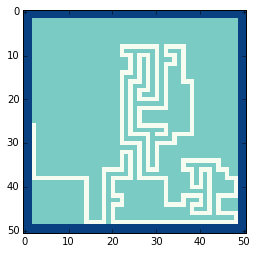

In [6]:
#this is a function used in the tunnel2 function below 
#dig code makes a single linear tunnel by checking two forward AND moving two forward by changing 1s to 0s
def dig(maze,x,y):
    d=random.randint(0,3) #pick a random start direction
    yc=[-1,1,0,0] #y coordinates for north, south, east west
    xc=[0,0,1,-1] #x coordinates for north, south, east west
    while (maze[y+yc[0]*2][x+xc[0]*2])==1 or (maze[y+yc[1]*2][x+xc[1]*2])==1 or (maze[y+yc[2]*2][x+xc[2]*2])==1 or (maze[y+yc[3]*2][x+xc[3]*2])==1: 
    #while any one of the four directions is a 1 then try to move
    #otherwise no movement digging happens 
        ny=y+yc[d]
        nx=x+xc[d]
        if maze[ny][nx]==1: #make sure you won't go out of index by checking 1 forward first 
            if maze[ny+yc[d]][nx+xc[d]]==1:
            #if next two spaces are clear for current direction 
                maze[ny][nx]=0 #tunnel there 
                maze[ny+yc[d]][nx+xc[d]]=0 #tunnel foward twice 
                y=ny+yc[d] #update location to 2 forward
                x=nx+xc[d] #update location to 2 forward
                d=picknd(d) #then pick another direction
            else:
                d=picknd(d)
        else: 
            d=picknd(d) #if the next two spots are NOT empty, pick a new location
        #will keep picking a new direction until find a spot that is occupied by a 1 
        #if there are no 1s in all 4 directions then nothing happens as specified by while loop
        
#testing dig code to make a maze of any size 
dim=51
mazeZ=createmaze(dim)
#start at [50%][0] real coordinates: (0,50%)
starty=random.randrange(2,dim-2,2) #start on random an even space 
startx=2#start on the edge 
mazeZ[starty][startx]=0 #make that space a 0
dig(mazeZ,startx,starty) #requires the maze and the start location
imshow(mazeZ,"GnBu",interpolation="nearest")
print starty
print startx

# Step Four: Adding branches to the linear tunnel
Here I created a function called tunnel2 that uses the dig function to first make a single linear tunnel as above. Then the function searches all tunnels (all 0s) to choose a spot to make a branch from. New branches will continue to be generated until the maze is full (i.e. there are no possible spots to make branches from). 

The first function below is check which is used in tunnel2 to see if the randomly chosen spot on already generated tunnels actually has a place to make a new tunnel.

The second function below is mazefull which is used in tunnel2 to see if the maze is full. If the maze is full it will stop attempting to make branches. 

28
2


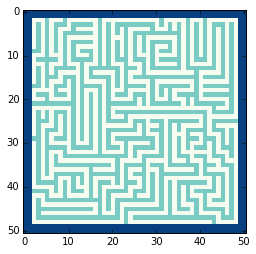

In [7]:
#make tunnels with multiple branches within the maze area (function for ratmaze function below)

def check(maze,by,bx): #check to make sure the chosen location has a place to go
    yc=[-1,1,0,0] #y coordinates for north, south, east west
    xc=[0,0,1,-1] #x coordinates 
    bn=maze[by+yc[0]+yc[0]][bx+xc[0]+xc[0]]
    bs=maze[by+yc[1]+yc[1]][bx+xc[1]+xc[1]]
    be=maze[by+yc[2]+yc[2]][bx+xc[2]+xc[2]]
    bw=maze[by+yc[3]+yc[3]][bx+xc[3]+xc[3]]   
    if bn==1 or bs==1 or be==1 or bw==1:
        return True
    else:
        return False 

def mazefull(maze,xDim,yDim): #function to check if the maze is full so code knows when to stop
        truespots=list()
        for y in range(2,yDim,2): #specific to a 49x49  maze
            for x in range(2,xDim,2): #specific to a 49x49 maze
                if maze[y][x]==0:
                    if check(maze,y,x)==True:
                        truespots.append(1)
        if len(truespots)==0:
            return True
        else:
            return False

def tunnel2(maze,x,y,xDim,yDim): #need maze area, start x, start y
    dig(maze,x,y) #dig the first linear tunnel until hit a dead end 
    #all code below this is for then using dig code to add branches 
    #make sure  branch spot has a potential direction 
        
    while mazefull(maze,xDim,yDim)==False: #while maze is not full dig branches   
        #pick x and y coordinates to dig another tunnel 
        by=random.randrange(2,yDim,2) #specific to a 49x49 maze
        bx=random.randrange(2,xDim,2) #specific to a 49x49 maze 
        #keeping picking 0s that have potential directions to branch until you find one 
        while maze[by][bx]!=0 or check(maze,by,bx)==False and mazefull(maze,xDim,yDim)==False:
        #while spot is not a zero or spot is closed and the whole maze is not full pick a new spot to branch:
            by=random.randrange(2,yDim,2)
            bx=random.randrange(2,xDim,2) 
        dig(maze,bx,by) #attempt to dig (if there is nowhere to dig, dig will not execute)
    
    return maze
        
#testing tunnel2 code to make a maze of any size 
dim=51
yDim=dim
xDim=dim
mazeZ=createmaze(dim)
#start at [50%][0] real coordinates: (0,50%)
starty=random.randrange(2,dim-2,2) #start on random an even space 
startx=2#start on the edge 
mazeZ[starty][startx]=0 #make that space a 0
tunnel2(mazeZ,startx,starty,xDim,yDim) #requires the maze and the start location
imshow(mazeZ,"GnBu",interpolation="nearest")
print starty
print startx

# Step Five: Pick the end location 
The start location is always located on the western wall (x=2 and y is random even number). Before an agent can solve the maze I needed to define the end location. I wanted the end to be on a wall and intuitevely it seemed to me that a dead-end is a better end spot than a continous tunnel next to the wall. This is because an endspot in the middle of a length of a tunnel means that all tunnel after the endspot is essentially pointless. If the endspot is on a dead-end the agent could theoretically explore the entire maze before reaching the end location. This way no tunnel in the maze is "unexplorable". 

This function searches all the dead-ends that are touching the wall (adjacent to a 2 in the matrix), adds them to a list and randomly picks one. 

In [8]:
#function to pick an endspot (piece of ratmaze function below)
def findend(maze,starty,startx,yDim,xDim): #function to pick an endspot
    endspots=list()
    for y in range(2,yDim-1,2): 
        for x in range(2,xDim-1,2): 
            if maze[y][x]==0:
                yc=[-1,1,0,0] #y coordinates for north, south, east west
                xc=[0,0,1,-1] #x coordinates 
                bn=maze[y+yc[0]][x+xc[0]] #spot north of spot
                bs=maze[y+yc[1]][x+xc[1]] #spot south of spot
                be=maze[y+yc[2]][x+xc[2]] #spot east of spot
                bw=maze[y+yc[3]][x+xc[3]] #spot west of spot
                if bn==2 or bs==2 or be==2 or bw==2: #if one touching spot is a 2
                    #if one and only one location next to this spot is a 0
                    if ((bn==0 and bs!=0 and be!=0 and bw!=0) or (bn!=0 and bs==0 and be!=0 and bw!=0) or (bn!=0 and bs!=0 and be==0 and bw!=0) or (bn!=0 and bs!=0 and be!=0 and bw==0)) and (y!=starty and x!=startx):
                        endspots.append([y,x]) #make a list of all possible end spots
    return endspots

#test with mazeZ, starty, and startx as used in previous tests above 
print findend(mazeZ,starty,startx,yDim,xDim) #prints potential end locations 
print (starty,startx)
#end locations should be dead-ends that are touching the maze "wall" 
#end locations should not equal the start location! 
#note that the start location (second list) is not included in list of endspots (first list).

[[2, 8], [48, 42]]
(28, 2)


# Step Six: Assemble the maze in one function
Here I took all the functions from above and assembled them into a single function that will return the maze in addition to the start and end location indices. Here is where I make sure that the user can only make mazes of an odd number and that are at least 9x9. Mazes smaller than 9x9 run into errors finding the endspot. Mazes as small as 9x9 do still have endspot problems, but this code will generate a new maze if there are no possible endspots such that this function will always return a maze. 

It returns a list that looks like this (maze,[starty][startx],[endy][endx]). 

Maze Area (tunnel walls): 1

Maze Perimeter: 2 

Maze Tunnels: 0

Maze Start and End: 3

In [21]:
#final code for function that assembles the complete maze including start and end spots 
def ratmaze(dim): #will make a random maze as long as dim is odd
    if dim%2==0: 
        print "error: maze dimension must be an odd number"
    else: 
        if dim<8: #mazes of size 7 fail to generate (9 is smallest).
            print "error: maze must be at least 9x9"
        else:
            yDim=dim #must be odd number for maze to fill up completely to edges 
            xDim=dim #must be odd number for maze to fill up completely to edges 
            maze=createmaze(dim)

            #start at [50%][0] real coordinates: (0,50%)
            starty=random.randrange(2,yDim-2,2) #start on an even y space
            startx=2#start on the edge (even)
            maze[starty][startx]=0 #make start space a 0

            #tunnel
            tunnel2(maze,startx,starty,xDim,yDim)

            #check that maze actually has at least one endspot
            endspots=findend(maze,starty,startx,yDim,xDim)
            while len(endspots)==0: #if there is no endspot available make a new maze 
                #make a new maze
                maze=createmaze(dim)
                starty=random.randrange(2,yDim-2,2)
                startx=2
                maze[starty][startx]=0
                tunnel2(maze,startx,starty,xDim,yDim)
                endspots=findend(maze,starty,startx,yDim,xDim)

            #return start and end of maze 
            end=endspots[random.randint(0,len(endspots)-1)]
            start=[starty,startx]
            maze[start[0]][start[1]]=3 #make start spot a 3
            maze[end[0]][end[1]]=3 #make end spot a 3 
            return (maze,start,end) #return the maze and the start and end locations of the maze 

#test to make sure code works 
#some way to make the function just return the maze by default and return start and end
#coordinates if called specifically? 
mazeD=ratmaze(501)
print mazeD[1] #print start
print mazeD[2] #print end
imshow(mazeD[0], "GnBu",interpolation="nearest") #check (maze is first element returned)
#this takes about four second to execute on my computer 

KeyboardInterrupt: 

In [10]:
#test an even number
badmaze=ratmaze(80) #maze must be an odd number

error: maze dimension must be an odd number


# Step Seven: Make the rat (agent)
Now that we've finally assembled our maze I need to create the rat to solve the maze. The rat's current location will be indicated with a 5. 

The rat starts in the start maze location. When the rat is initialized with a particular maze the start location will change to a 5. The rat has several functions.

Function solve: 
First the rat can solve the maze after being intialized. The path the rat uses to explore tunnels will be indicated with 4s. When the rat hits a dead end it backtracks and the backtracked path is indicated with 6s. If the rat is adjacent to a 0, it will explore the 0 and will only explore 4s if it's hit a dead end. It's path locations are saved in a list named Track. rat.Track will return this list. The solve function will also return the total number of steps it took to solve the maze. The rat stops exploring when it's self location is a 3. (since start location is turned into a 5, the only location in the entire maze that is a 3 is the end). 

Function reset: 
Next the rat can be reset. The maze's tunnels are reverted to 0s and the rat's current location is returned to the start location. the rat.Track is saved unless the solve function is executed a second time, in which case it is over-written. 

Function learn: 
After resetting the rat can be told to solve the maze a second time. Or the rat can "learn" the maze with the learn function where it will delete all back-tracking (6s) from it's track. Removing the 6s results in a single linear path of 4s from the start to end location. 

Executing rat.solve, rat.reset, rat.learn will immediately return the solution to a maze making this an excellent maze solving tool. The rat class will only accept mazes in the form of a list that contains the maze, the start location, and the end location. 

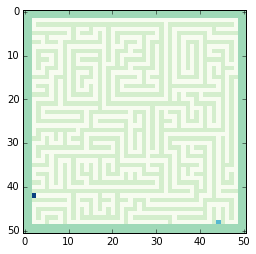

In [11]:
#create the rat! 

#0 tunnel
#1 tunnel wall
#2 maze wall
#3 maze end (and start until rat is placed in maze)
#4 rat's tracks
#5 rat's current location
#6 rat's double tracks 

#this class can show you its current X and Y, it's Track (once solved) and the solution (once solved and maze reset).

class rat:
    def __init__(self,mazeA):
    #initalize rat 
        self.Y=mazeA[1][0]
        self.X=mazeA[1][1]
        self.maze=mazeA[0]
        self.maze[self.Y][self.X]=5 #mark where the rat currently is with a 5 
        self.starty=mazeA[1][0]
        self.startx=mazeA[1][1]
        self.endy=mazeA[2][0]
        self.endx=mazeA[2][1]
        imshow(self.maze, "GnBu", interpolation="nearest")

    def solve(self):
        self.Track=list()
        self.Track.append([self.Y,self.X])
        while self.maze[self.Y][self.X]!=3:
            yc=[-1,1,0,0] #y coordinates for north, south, east west
            xc=[0,0,1,-1] #x coordinates 
            n=self.maze[self.Y+yc[0]][self.X+xc[0]] #spot north of spot
            s=self.maze[self.Y+yc[1]][self.X+xc[1]] #spot south of spot
            e=self.maze[self.Y+yc[2]][self.X+xc[2]] #spot east of spot
            w=self.maze[self.Y+yc[3]][self.X+xc[3]] #spot west of spot

            #if adjacent spot is a 3 move there and finish!  
            if n==3 or s==3 or e==3 or w==3:
                d=random.randint(0,3)
                while self.maze[self.Y+yc[d]][self.X+xc[d]]!=3:
                    #keep picking a random direction until you get one that is equal to three 
                    d=random.randint(0,3)
                self.maze[self.Y][self.X]=4 #make old spot a 4 for tracking
                self.Y=self.Y+yc[d]
                self.X=self.X+xc[d]
                self.Track.append([self.Y,self.X])

            if self.maze[self.Y][self.X]!=3: #if the rat's current location is not a three, move! 

                numberdirections=list()
                if n==0:
                    numberdirections.append(1)
                if s==0:
                    numberdirections.append(1)
                if e==0:
                    numberdirections.append(1)
                if w==0:
                    numberdirections.append(1)

                #if only one direction to go, go there
                if len(numberdirections)==1: 
                    if (n==0 and s!=0 and e!=0 and w!=0): #if north is the only possible way to go, go there
                        d=0
                    if (n!=0 and s==0 and e!=0 and w!=0):
                        d=1
                    if (n!=0 and s!=0 and e==0 and w!=0):
                        d=2
                    if (n!=0 and s!=0 and e!=0 and w==0):
                        d=3
                    self.maze[self.Y][self.X]=4 #make old spot a 4 for tracking
                    self.Y=self.Y+yc[d]
                    self.X=self.X+xc[d]
                    self.Track.append([self.Y,self.X])
                    self.maze[self.Y][self.X]=5 #make new spot the rat 

                #if more than one direction to go randomly pick one of them
                if len(numberdirections)>1: 
                    d=random.randint(0,3) #pick a random direction
                    while self.maze[self.Y+yc[d]][self.X+xc[d]]!=0:
                        #keep picking a random direction until you get one that is equal to zero 
                        d=random.randint(0,3)
                    self.maze[self.Y][self.X]=4 #make old spot a 4 for tracking
                    self.Y=self.Y+yc[d]
                    self.X=self.X+xc[d]
                    self.Track.append([self.Y,self.X])
                    self.maze[self.Y][self.X]=5 #make new spot the rat 

                #if there is nowhere to go backtrack!     
                if len(numberdirections)==0: 
                    d=random.randint(0,3)
                    while self.maze[self.Y+yc[d]][self.X+xc[d]]!=4: #make new direction the spot that is old track
                        d=random.randint(0,3)
                    #move to old spot (backtrack)
                    self.maze[self.Y][self.X]=6 #make old spot a 6 for backtracked
                    self.Y=self.Y+yc[d]
                    self.X=self.X+xc[d]
                    self.Track.append([self.Y,self.X])
                    self.maze[self.Y][self.X]=5 #make new spot the rat 
            else: 
                print "found the cheese in "+str(len(self.Track))+" steps!"
        imshow(self.maze, "GnBu", interpolation="nearest")
        
        #record the solution 
        self.solution=list()
        #for each place in the track that is not a backtrack add to to a new list for the shortest path
        for i in range(len(self.Track)):
            if self.maze[self.Track[i][0]][self.Track[i][1]]!=6:
                self.solution.append(self.Track[i])
        #return self.solution
    
    def reset(self):
        for i in range((len(self.Track)-1)):
            self.maze[self.Track[i][0]][self.Track[i][1]]=0 #make the whole track 0s again
            self.maze[self.Y][self.X]=0 #including the last spot 
        #self.maze[self.starty][self.startx]=5 #make start a 5 with rat 
        self.maze[self.endy][self.endx]=3 #make end a 3 
        self.Y=self.starty #reset starting position back to start
        self.X=self.startx #reset starting position back to start 
        self.maze[self.Y][self.X]=5 #make self a 5 
        imshow(self.maze, "GnBu", interpolation="nearest")
            
    def learn(self): #must reset the maze first 
        for i in range(len(self.solution)-1):
            self.maze[self.solution[i][0]][self.solution[i][1]]=4 #fill maze with 4s for solution
        self.maze[self.starty][self.startx]=3 #mark start with a 3
        self.maze[self.endy][self.endx]=3 #mark end with a 3
        imshow(self.maze, "GnBu", interpolation="nearest")
        print "the shortest path is "+str(len(self.solution))+" steps!"
            
#test
ratty=rat(mazeD) #mazeD was used to test the ratmaze function
#NOTE: mazeZ used in prior examples will not work because mazeZ is JUST the maze whereas mazeD is a list of three things: the maze, the start, and the end spots 
#0 tunnel (lightest color)
#1 tunnel wall
#2 maze wall
#3 maze end (and start until rat is placed in maze)
#4 rat's tracks
#5 rat's current location (darkest color)
#6 rat's double tracks 
            

# Step Eight: Executing the project
In the following cells I will actually execute all the code above together. First I will make a maze and put the rat in the maze. I also printed the start and end coordinates. 

[30, 2]
[2, 20]


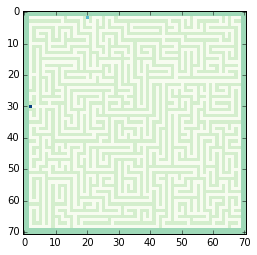

In [12]:
#actual execution of project 

algernonsmaze=ratmaze(71) #make the maze
print algernonsmaze[1] #print start coordinates (Y,X)
print algernonsmaze[2] #print end coordinates (Y,X)
algernon=rat(algernonsmaze)  # put the rat in the generated maze 
#rat's current location is entered as 5

### Step 8.2 Now I will have the rat solve the maze.
The darkest color is a 6, which indicates backtracking. The second darkest color indicates the single correct solution to the maze. 

found the cheese in 1651 steps!


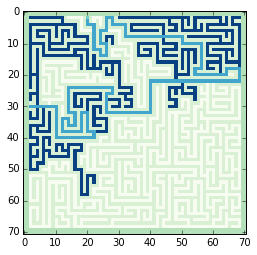

In [13]:
algernon.solve()
#excuting the solve function will make the rat will go through the maze until it finds a 3 (end location)
#it will also report how many steps it took to reach the end 

### Step 8.3 Some things that can be called from the rat class 
By default when solving the rat class will return number of steps to solve but you can also call this by looking at the length of the track. The solution is also saved when the solve function is executed and it can be called as well. The length of the single shortest path (solution) can also be called. Finally the rat's current location can be asked for and this should be the end coordinates to the maze.  

In [14]:
#this is just an example of some types of information we can extract from class:rat
print "steps to solve: "+str(len(algernon.Track)) #this will also return the number of steps to find the cheese
print algernon.solution #this will return the final solution
print "shortest path: "+str(len(algernon.solution)) #what's the shortest path? 
print (algernon.Y,algernon.X) #this wil show current location (Y,X), should be end coordinates

steps to solve: 1651
[[30, 2], [30, 3], [30, 4], [30, 4], [30, 4], [30, 5], [30, 6], [30, 6], [30, 7], [30, 8], [30, 9], [30, 10], [31, 10], [32, 10], [33, 10], [34, 10], [35, 10], [36, 10], [37, 10], [38, 10], [39, 10], [40, 10], [40, 11], [40, 12], [40, 13], [40, 14], [40, 15], [40, 16], [40, 17], [40, 18], [40, 19], [40, 20], [40, 21], [40, 22], [39, 22], [38, 22], [38, 22], [38, 21], [38, 20], [37, 20], [36, 20], [35, 20], [34, 20], [33, 20], [32, 20], [32, 20], [32, 19], [32, 18], [33, 18], [34, 18], [35, 18], [36, 18], [37, 18], [38, 18], [38, 17], [38, 16], [38, 15], [38, 14], [38, 13], [38, 12], [37, 12], [36, 12], [35, 12], [34, 12], [34, 13], [34, 14], [35, 14], [36, 14], [36, 15], [36, 16], [35, 16], [34, 16], [33, 16], [32, 16], [32, 15], [32, 14], [31, 14], [30, 14], [29, 14], [28, 14], [27, 14], [26, 14], [25, 14], [24, 14], [24, 15], [24, 16], [24, 17], [24, 18], [24, 19], [24, 20], [24, 21], [24, 22], [24, 23], [24, 24], [24, 25], [24, 26], [24, 27], [24, 28], [25, 28],

### Step 8.4 Reset the maze
Resetting the maze does not erase the track or the solution. It just clears the maze itself and returns the locatio of the rat to the start location. 

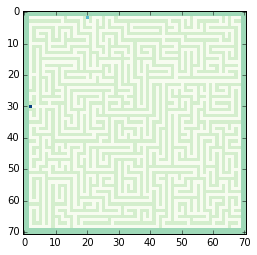

In [15]:
#you can reset the maze to see how many steps a second try takes 
algernon.reset()

### Step 8.5 Solve it again.
Solving the maze again the rat's track will almost certainly be different. The maze MUST be reset before the rat can solve it a second time. 

found the cheese in 1143 steps!


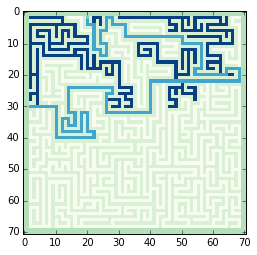

In [16]:
algernon.solve() #after resetting try solving again!

### Step 8.6 Show the solution 
In order to show the solution in the maze without all the backtracking you must reset the maze and then execute the learn function. The learn function does not actually save the solution. The solution is saved during the solve function. The learn function just shows the solution. I.e. the rat perfectly remembers the correct solution and when asked to learn the maze, will show you the single shortest path. 

the shortest path is 266 steps!


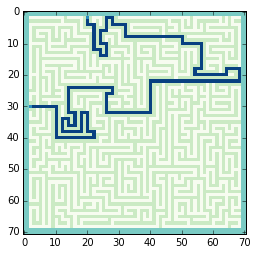

In [17]:
algernon.reset() #clear the maze again
algernon.learn() #and show the shortest path (solution) 

# Step Nine: Final testing
Executing all these functions consecutively will return a random maze of a specified size with the single solution shown. It will also print the number of steps to solve, and the length of the final solution. 

found the cheese in 2397 steps!
the shortest path is 332 steps!


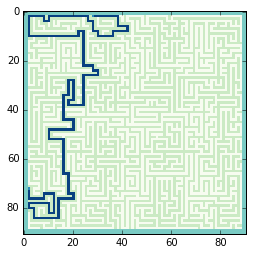

In [22]:
maze2=ratmaze(91) #generate maze of dimension 11x11
luna=rat(maze2) #put rat in generated maze
luna.solve() #solve it
luna.reset() #reset it
luna.learn() #show shortest path 
#this is all the code you need to show the solution a random maze 
#with a maze of size 99 this takes about 4 seconds 
#a maze of size 121 took about 20 seconds to solve 
#I didn't have the patience to test a maze larger than 251 (501 was taking more than twenty minutes)